# Pylids demo

This notebook demonstrates the use of pylids, a package to label pupils and eyelids for gaze estimation (and other tasks). Pylids is based on [DeepLabCut](http://www.mackenziemathislab.org/deeplabcut) and the code is described in [Biswas & Lescroart (2023)](https://link.springer.com/article/10.3758/s13428-023-02266-3)

In [1]:
import pylids
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

Loading DLC 3.0.0rc8...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


For deplyoment please use model `pytorch_eyelid_pupils_v1` for pupil estimation and `pytorch_eyelids_v1` for eyelid estimation. 

### Run pylids on a eye video

In [3]:
#This is the main function you want to use to estimate pupil and eyelids
#checkout the docstring for how to use this function
pylids.analyze_video?

In [4]:
#running these on included demo eye videos
!ls *.mp4

eye0.mp4  eye1.mp4


In [5]:
#Demo run on eye1.mp4 included with the repo
pylids_out = pylids.analyze_video(eye_vid='eye1.mp4', model_name= 'pytorch_eyelid_pupils_v1', save_vid=True)

Done! 

Analyzing videos with /home/arnab/.config/pylids/pytorch_eyelid_pupils_v1/dlc-models-pytorch/iteration-0/santini_eyelid_detectionJul182025-trainset99shuffle1/train/snapshot-best-030.pt
Starting to analyze eye1.mp4
Video metadata: 
  Overall # of frames:    600
  Duration of video [s]:  10.00
  fps:                    60.0
  resolution:             w=640, h=480

Running pose prediction with batch size 8


100%|████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:13<00:00, 43.81it/s]


Saving results in /tmp/tmprlbyi7x4/eye1DLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_030.h5 and /tmp/tmprlbyi7x4/eye1DLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_030_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

['/tmp/tmprlbyi7x4/eye1DLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_030.h5']
Analyzed video saved in ./eye_annotation.mp4


In [6]:
## Output is a dictionary with the following keys
pylids_out.keys()

dict_keys(['dlc_kpts_x', 'dlc_kpts_y', 'dlc_confidence', 'eyelid_up_y', 'eyelid_lo_y', 'eyelid_x', 'ellipse', 'confidence', 'norm_pos', 'diameter', 'id'])

In [7]:
## The ellipse is stored as a dictionary with keys which define the ellipse parameters
pylids_out['ellipse'][0].keys()

dict_keys(['axes', 'angle', 'center'])

#The output of the function above is a dictionary with the following keys

'''

    pylids_out['dlc_kpts_x'] : DeepLabCut keypoints x coordinates [:32 for eyelids, 32: for pupils]
    pylids_out['dlc_kpts_y'] : DeepLabCut keypoints y coordinates [:32 for eyelids, 32: for pupils]
    pylids_out['ellipse'] : This is dictonary with pupil ellipse fit parameters
    pylids_out['ellipse'][frame_number]['axes'] : the major and minor axes of the ellipse
    pylids_out['ellipse'][frame_number]['angle'] : the angle of the ellipse
    pylids_out['ellipse'][frame_number]['center'] : the center of the ellipse

    pylids_out['confidence'] : average confidence of DeepLabCut keypoints
    pylids_out['norm_pos'] : center of the pupil center normalibed by the eye image size 
    pylids_out['diameter'] : average of the major and minor axes of the ellipse
'''

## Visualizing the output

In [8]:
#make a visualization of the output by plotting the ellipse and eyelids for 10 random frames
def visualize_pylids_out(video_path, pylids_output, frame_list = None):
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    fig, ax = plt.subplots(2, 5, figsize=(10,3), dpi=100)
    for ax in ax.flatten():
        ax.axis('off')
        #randomly select a frame to visualize
        frame_num = np.random.randint(0, len(pylids_output['ellipse']))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        ax.imshow(frame)
        #visualize the eyelids
        ax.plot(pylids_output['eyelid_x'][frame_num], pylids_output['eyelid_lo_y'][frame_num], 'r')
        ax.plot(pylids_output['eyelid_x'][frame_num], pylids_output['eyelid_up_y'][frame_num], 'r')
        #now visualize the pupil
        center_x, center_y = pylids_output['ellipse'][frame_num]['center']
        width, height = pylids_output['ellipse'][frame_num]['axes']
        theta = pylids_output['ellipse'][frame_num]['angle']
    
        ellipse = patches.Ellipse((center_x, center_y), width, height, fill =False, angle=theta, edgecolor='red')
        ax.add_patch(ellipse)
    plt.tight_layout()


In [9]:
%matplotlib inline

## Visualizing the eye frames overlaid with the pylids fits

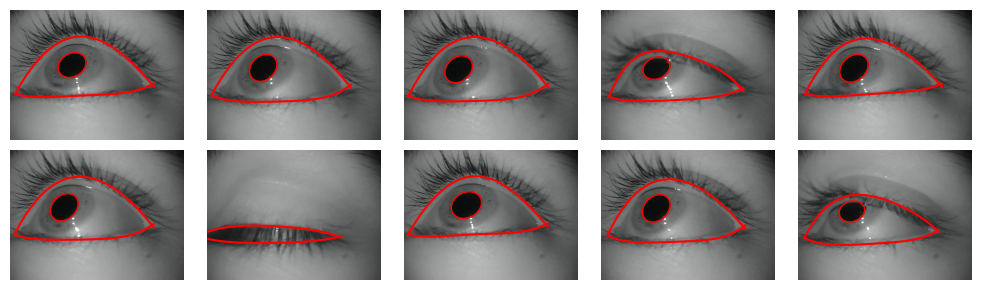

In [25]:
visualize_pylids_out('eye1.mp4', pylids_out)

The pylids output is a heirarchical dictonary, it may be easier to work with the output if we convert it to a dictory of arrays. This is specifically useful for `pylids_out['ellipse']`

In [26]:
#Useful funtion to convert the heirarchical output to a dictonary of arrays
pylids_ellipses = pylids.utils.dictlist_to_arraydict(pylids_out['ellipse'])

# We now have our output in the format pylids_ellipses[ellipse_param][frame_num]
pylids_ellipses.keys()

dict_keys(['axes', 'angle', 'center'])

Visualizing pupil centers across time using the array we just created

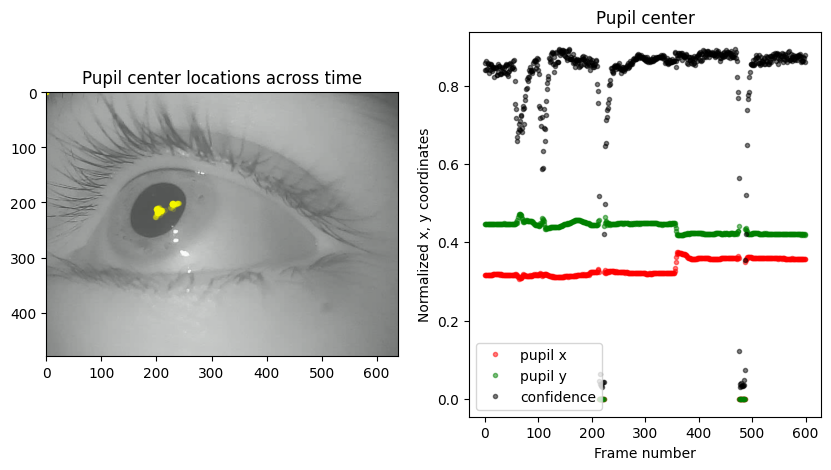

In [27]:
cap = cv2.VideoCapture('eye1.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()

#Plotting the first frame of the video

#Plotting the pupil ellipses across all frames
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=100)
axs[0].imshow(frame, alpha =0.7)
axs[0].plot(pylids_ellipses['center'][:,0], pylids_ellipses['center'][:,1], '.', color= 'yellow', alpha = 0.1)
axs[0].set_title('Pupil center locations across time')
axs[1].plot(pylids_out['norm_pos'][:,0],'.', color= 'red', label = 'pupil x', alpha = 0.5)
axs[1].plot(pylids_out['norm_pos'][:,1],'.', color= 'green', label = 'pupil y', alpha = 0.5)
axs[1].plot(pylids_out['confidence'], '.', label = 'confidence', color = 'black', alpha = 0.5)
axs[1].set_title('Pupil center')
axs[1].set_xlabel('Frame number')
axs[1].set_ylabel('Normalized x, y coordinates')
axs[1].legend()